In [1]:
from __future__ import division
import os
import sys
import pdb
import time
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset

import cv2
import numpy as np
import pandas as pd
from sklearn import preprocessing
from collections import OrderedDict
from matplotlib import pyplot as plt

In [1]:
!ls ./

data	      metadata.h5  training.h5	   tutorials
metadata.csv  tests.ipynb  training.ipynb


In [120]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [4]:
draw_boxes(image, boxes):
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin
    

SyntaxError: invalid syntax (<ipython-input-4-8430df7b797e>, line 1)

In [2]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from matplotlib import image

import torchvision.transforms as transforms

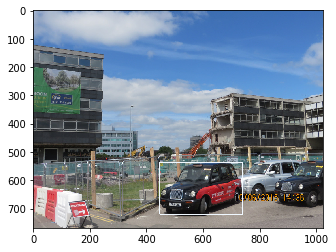

In [131]:
colors = list(ImageColor.colormap.values())

with h5py.File('training.h5', 'r') as h5f:
    # print(h5f['ids'].shape)
    # print(h5f['annotations'].shape)
    annotations = h5f['annotations'][35]
    img_id = h5f['ids'][35]
    xmin, xmax, ymin, ymax = annotations
    # img = image.imread(f"/mnt/disks/open-images/images/train/{img_id}.jpg")
    img = Image.open(f"/mnt/disks/open-images/images/train/{img_id}.jpg")
    img = Image.fromarray(np.uint8(img)).convert("RGB")
    draw = ImageDraw.Draw(img)
    im_width, im_height = img.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=5,
              fill=colors[0])


    # img_path = cv2.imread(f"/mnt/disks/open-images/images/train/{img_id}.jpg")
    # img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)        
    plt.imshow(img)
    plt.show()

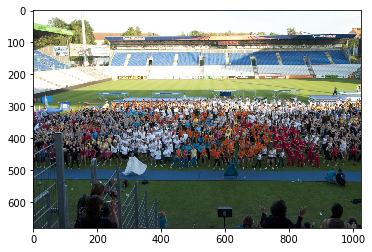

In [6]:
img_id = "55558de0ee48ecf6"
img = Image.open(f"/mnt/disks/open-images/images/train/{img_id}.jpg")
plt.imshow(img)
plt.show()

In [78]:
def pad_to_square(img, pad_value=0):
    z, y, x = img.shape
    if x == y: return img
    
    dim_diff = np.abs(y - x)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if y <= x else (pad1, pad2, 0, 0)
    target = F.pad(img, pad, mode="constant", value=pad_value)
    return target, pad

In [79]:
def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

In [80]:
def convert_annotations(annotations):
    x_min, x_max, y_min, y_max = annotations
    width = x_max - x_min
    height = y_max - y_min
    x_center = (width / 2) + x_min
    y_center = (height / 2) + y_min
    return [width, height, x_center, y_center]

In [81]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    # label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    # cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [125]:
def resize_and_pad(im):
    # https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
    desired_size = 416

    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))
    before_padding = im.shape
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im, delta_w, delta_h, before_padding 

In [13]:
with h5py.File('training.h5', 'r') as h5f:
    print(h5f['annotations'][:])

[[0.       0.       0.       0.      ]
 [0.0125   0.195312 0.148438 0.5875  ]
 [0.025    0.276563 0.714063 0.948438]
 ...
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]]


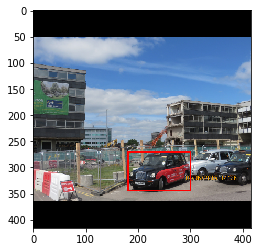

In [140]:
# Convert annotations and test on resized/padded image
with h5py.File('training.h5', 'r') as h5f:
    
    # Read image
    img_id = h5f['ids'][35]
    img_path = f"/mnt/disks/open-images/images/train/{img_id}.jpg"    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # Resize image and apply padding
    img, padding_x, padding_y, without_padding = resize_and_pad(img)
    unpad_h, unpad_w, _ = without_padding
    
    # Read annotations (bboxes)
    annotations = h5f['annotations'][35]
    w, h, x_center, y_center = convert_annotations(annotations)
    
    # Adjust x,y center for padding
    x_center += (padding_x / 2) / unpad_w
    y_center += (padding_y / 2) / unpad_h
    
    # Display bounding box
    # x1 = (x_center + ((padding / 2) / old_width) - width / 2) * old_width
    x1 = (x_center - w / 2) * unpad_w
    y1 = (y_center - h / 2) * unpad_h
    x2 = (x_center + w / 2) * unpad_w
    y2 = (y_center + h / 2) * unpad_h
    top_left = (int(x1), int(y1))
    bottom_right = (int(x2), int(y2))
    img = cv2.rectangle(img, top_left, bottom_right, (255,0,0), 2)
    
    plt.imshow(img)
    plt.show()

In [142]:
with h5py.File('training.h5', 'r') as h5f:
    annotations = h5f['annotations']
    print(annotations)

<HDF5 dataset "annotations": shape (14610230, 4), type "<f8">


In [ ]:
# Backup
# # Convert annotations and test on resized/padded image
# with h5py.File('training.h5', 'r') as h5f:
    
#     # COLORS = np.random.uniform(0, 255, size=(len(classes), 3))
#     img_id = h5f['ids'][178]
#     img_path = f"/mnt/disks/open-images/images/train/{img_id}.jpg"    
#     img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
#     img, padding, before_padding = resize_and_pad(img)
# #
#     old_height, old_width, _ = before_padding
#     img_height, img_width, img_channels = img.shape
#     annotations = h5f['annotations'][178]
#     x_min, x_max, y_min, y_max = annotations
#     width, height, x_center, y_center = convert_annotations(annotations)
#     x1 = (x_center + ((padding / 2) / old_width) - width / 2) * old_width
#     y1 = (y_center + height / 2) * img_height
#     x2 = (x_center + ((padding / 2) / old_width) + width / 2) * old_width
#     y2 = (y_center - height / 2) * img_height
#     top_left = (int(x1), int(y1))
#     bottom_right = (int(x2), int(y2))
#     img = cv2.rectangle(img, top_left, bottom_right, (255,0,0), 3)
# #

#     plt.imshow(img)
#     plt.show()

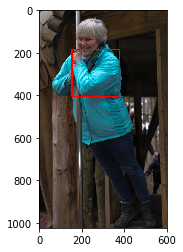

In [30]:
# Convert annotations

with h5py.File('training.h5', 'r') as h5f:
    
    # COLORS = np.random.uniform(0, 255, size=(len(classes), 3))
    img_id = h5f['ids'][178]
    img_path = f"/mnt/disks/open-images/images/train/{img_id}.jpg"    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_height, img_width, img_channels = img.shape
    
    annotations = h5f['annotations'][178]
    x_min, x_max, y_min, y_max = annotations
    
    width, height, x_center, y_center = convert_annotations(annotations)
    x1 = (x_center - width / 2) * img_width
    y1 = (y_center + height / 2) * img_height
    x2 = (x_center + width / 2) * img_width
    y2 = (y_center - height / 2) * img_height
    top_left = (int(x1), int(y1))
    bottom_right = (int(x2), int(y2))
    bbox_img = cv2.rectangle(img, top_left, bottom_right, (255,0,0), 3)
    plt.imshow(bbox_img)
    plt.show()

In [20]:
colors = list(ImageColor.colormap.values())
target_size = 416
with h5py.File('training.h5', 'r') as h5f:
    img_id = h5f['ids'][178]
    img_path = f"/mnt/disks/open-images/images/train/{img_id}.jpg"
    img = Image.open(img_path).convert('RGB')
    
    # Get annotations
    annotations = h5f['annotations'][178]
    xmin, xmax, ymin, ymax = annotations
    
    # Draw boxes
    draw = ImageDraw.Draw(img)
    im_width, im_height = img.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    pdb.set_trace()
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=5,
              fill=colors[0])    
    

    plt.imshow(img)
    plt.show()
    
    # convert image to tensor
    img_tensor = transforms.ToTensor()(img)

    # image processing
    padded_img, padding = pad_to_square(img_tensor)
    resized_img = resize(padded_img, target_size)
    
    # process annotations
    convert_annotations(annotations)
    
    # transposed_img = np.transpose(img_tensor.numpy(), (1, 2, 0))
    # final_img = Image.fromarray(np.uint8(transposed_img))
    # final_img = transforms.ToPILImage()(img_tensor)

    # convert tensor to image
    # final_img = resized_img.permute(1, 2, 0)
    final_img = transforms.ToPILImage()(resized_img)
    
    draw2 = ImageDraw.Draw(final_img)
    im_width2, im_height2 = final_img.size
    
    resize_ratio = im_width/target_size
    (left, right, top, bottom) = (xmin * im_width2, xmax * im_width2,
                                  ymin * im_height2, ymax * im_height2)

    draw2.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=5,
              fill=colors[100])
        
    
    
    plt.imshow(final_img)
    plt.show()

> <ipython-input-20-858c7f150446>(18)<module>()
-> draw.line([(left, top), (left, bottom), (right, bottom), (right, top),


(Pdb)  left


154.61387999999997


(Pdb)  im_width


599


(Pdb)  q


BdbQuit: 

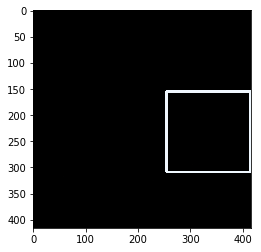

In [21]:
colors = list(ImageColor.colormap.values())

with h5py.File('training.h5', 'r') as h5f:
    # print(h5f['ids'].shape)
    # print(h5f['annotations'].shape)
    annotations = h5f['annotations'][29]
    img_id = h5f['ids'][29]
    xmin, xmax, ymin, ymax = annotations
    img_path = f"/mnt/disks/open-images/images/train/{img_id}.jpg"
    img = Image.open(img_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img)
    # img = Image.fromarray(np.uint8(img)).convert("RGB")
    # pdb.set_trace()
    img, pad = pad_to_square(img_tensor)
    output_size = 416
    img = resize(img, output_size)
    
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = Image.fromarray(np.uint8(img)).convert("RGB")
    
    draw = ImageDraw.Draw(img)
    im_width, im_height = img.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=5,
              fill=colors[0])


    # img_path = cv2.imread(f"/mnt/disks/open-images/images/train/{img_id}.jpg")
    # img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)        
    plt.imshow(img)
    plt.show()

In [52]:
img = image.imread(f"/mnt/disks/open-images/images/train/{img_id}.jpg")

In [57]:
torch.from_numpy(img).shape

torch.Size([768, 1024, 3])